# Comparison of Multiple Models/Methods

This notebook compares metrics from multiple CSV files, each representing a different model or method's performance.

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
%matplotlib inline

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [ ]:
base_save_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/figures'

# 현재 날짜 및 시간 자동 설정
from datetime import datetime
now = datetime.now()
# 날짜 및 시간 포맷 설정
date_format = "%Y%m%d"
time_format = "%H%M%S"
# 날짜 및 시간 문자열 생성
date = now.strftime(date_format)
time = now.strftime(time_format)
# 추가 정보 없으면 None
additional_info = input("Enter additional info (or leave blank): ")
if not additional_info:
    additional_info = None
# 날짜 및 시간에 따라 디렉토리 생성
save_dir_path = os.path.join(base_save_dir_path, date, time)
if additional_info:
    save_dir_path = f'{save_dir_path}_{additional_info}'
# 디렉토리 생성
if not os.path.exists(save_dir_path):
    os.makedirs(save_dir_path)

In [152]:
def load_metrics_files(file_paths, model_names=None):
    """
    Load multiple metrics CSV files into a dictionary of DataFrames.
    
    Args:
        file_paths (list): List of file paths to CSV files
        model_names (list, optional): Names to use for each model. If None, will use filenames.
        
    Returns:
        dict: Dictionary with model names as keys and DataFrames as values
    """
    if model_names is None:
        model_names = [os.path.basename(path).split('.')[0] for path in file_paths]
    
    if len(model_names) != len(file_paths):
        raise ValueError("Length of model_names must match length of file_paths")
    
    dataframes = {}
    for i, path in enumerate(file_paths):
        try:
            df = pd.read_csv(path)
            dataframes[model_names[i]] = df
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    return dataframes

In [153]:
def prepare_metrics_for_comparison(dataframes_dict):
    """
    Prepare metrics for comparison by adding model column and concatenating.
    
    Args:
        dataframes_dict (dict): Dictionary with model names as keys and DataFrames as values
        
    Returns:
        DataFrame: Combined DataFrame with model column
        list: List of metric columns found in the data
    """
    all_dfs = []
    
    for model_name, df in dataframes_dict.items():
        # Create a copy to avoid modifying the original
        df_copy = df.copy()
        df_copy['model'] = model_name
        all_dfs.append(df_copy)
    
    # Concatenate all dataframes
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    # Get metric columns (exclude 'file', 'model', etc.)
    metric_columns = [col for col in combined_df.columns if col not in ['file', 'model', 'HP']]
    
    return combined_df, metric_columns

In [154]:
# Modified plot_boxplots function
def plot_boxplots(combined_df, metric_columns, figsize=(14, 10)):
    """Plot boxplots for each metric across different models"""
    num_metrics = len(metric_columns)
    cols = 2
    rows = (num_metrics + cols - 1) // cols
    
    # Create a color palette dictionary based on unique models
    models = sorted(combined_df['model'].unique())
    model_colors = {model: f'C{i}' for i, model in enumerate(models)}
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows > 1 or cols > 1 else [axes]
    
    for i, metric in enumerate(metric_columns):
        if i < len(axes):
            # Pass the palette so each box (model) has its own color
            sns.boxplot(x='model', y=metric, data=combined_df, ax=axes[i], palette=model_colors)
            axes[i].set_title(f"{metric} Distribution")
            axes[i].set_xlabel('')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    # Save the figure before showing
    plt.savefig(os.path.join(save_dir_path, 'boxplots.png'))
    plt.show()

In [155]:
# Modified plot_radar_chart function
def plot_radar_chart(dataframes_dict, metrics_to_plot, figsize=(10, 10)):
    """
    Create a radar chart comparing models across selected metrics.
    
    Args:
        dataframes_dict (dict): Dictionary with model names as keys and DataFrames as values
        metrics_to_plot (list): List of metrics to include in the radar chart
    """
    # Calculate mean of each metric for each model
    model_means = {}
    for model_name, df in dataframes_dict.items():
        model_means[model_name] = [df[metric].mean() for metric in metrics_to_plot]
    
    # Set up radar chart
    num_metrics = len(metrics_to_plot)
    angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
    # Plot each model
    for model_name, means in model_means.items():
        means += means[:1]  # Close the loop
        ax.plot(angles, means, '-', linewidth=2, label=model_name)
        ax.fill(angles, means, alpha=0.1)
    
    # Set labels and legend
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_to_plot)
    ax.set_title('Model Comparison - Mean Metrics', size=15)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    # Save the radar chart to file
    plt.savefig(os.path.join(save_dir_path, 'radar_chart.png'))
    plt.show()

In [156]:
# Modified plot_performance_heatmap function
def plot_performance_heatmap(dataframes_dict, metric):
    """
    Create a heatmap showing each model's performance on each dataset for a specific metric.
    
    Args:
        dataframes_dict (dict): Dictionary with model names as keys and DataFrames as values
        metric (str): The metric to visualize
    """
    # Create a dataframe with rows=datasets, columns=models, values=metric scores
    datasets = set()
    for df in dataframes_dict.values():
        datasets.update(df['file'].tolist())
    datasets = sorted(list(datasets))
    
    # Create the comparison dataframe
    comparison_data = []
    for dataset in datasets:
        row = {'Dataset': dataset}
        for model, df in dataframes_dict.items():
            dataset_rows = df[df['file'] == dataset]
            if not dataset_rows.empty:
                row[model] = dataset_rows[metric].values[0]
            else:
                row[model] = np.nan
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.set_index('Dataset')
    
    # Create the heatmap
    plt.figure(figsize=(12, len(datasets) * 0.3))
    sns.heatmap(comparison_df, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': metric})
    plt.title(f'Comparison of {metric} Across Models')
    plt.tight_layout()
    # Save the heatmap before returning
    plt.savefig(os.path.join(save_dir_path, 'performance_heatmap.png'))
    return comparison_df

In [157]:
# Modified plot_metric_correlation function
def plot_metric_correlation(combined_df, metric_columns, figsize=(12, 10)):
    """Plot correlation heatmap between metrics"""
    # Calculate correlation matrix for metrics only
    corr_matrix = combined_df[metric_columns].corr()
    
    # Create mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
    
    plt.title('Correlation Between Metrics', fontsize=16)
    plt.tight_layout()
    # Save the correlation heatmap
    plt.savefig(os.path.join(save_dir_path, 'metric_correlation.png'))
    plt.show()

In [158]:
# Modified plot_metrics_summary function
def plot_metrics_summary(dataframes_dict, metric_columns, top_n=10):
    """
    Plot summary statistics for each model and identify top datasets.
    
    Args:
        dataframes_dict (dict): Dictionary with model names as keys and DataFrames as values
        metric_columns (list): List of metrics to summarize
        top_n (int): Number of top datasets to identify for each metric
    """
    # Calculate summary statistics
    model_summary = {}
    for model, df in dataframes_dict.items():
        stats = {metric: df[metric].mean() for metric in metric_columns}
        model_summary[model] = stats
    
    # Convert to DataFrame for easier plotting
    summary_df = pd.DataFrame(model_summary).T
    
    # Create model-specific color dictionary for consistent colors across plots
    models = list(dataframes_dict.keys())
    model_colors = {model: f'C{i}' for i, model in enumerate(models)}
    
    # Plot bar chart for each metric
    metrics_to_plot = [m for m in metric_columns if m != 'Time']  # Exclude Time
    
    num_metrics = len(metrics_to_plot)
    cols = 2
    rows = (num_metrics + cols - 1) // cols
    
    fig = plt.figure(figsize=(16, rows*4))
    gs = gridspec.GridSpec(rows, cols)
    
    for i, metric in enumerate(metrics_to_plot):
        ax = fig.add_subplot(gs[i])
        # Sort values for better visualization
        sorted_series = summary_df[metric].sort_values()
        
        # Plot bars with model-specific colors and add value labels
        for j, (model, value) in enumerate(sorted_series.items()):
            ax.barh(j, value, color=model_colors[model], label=model if i == 0 else "")
            ax.text(value, j, f" {value:.4f}", va='center', ha='left')  # value label at bar's end
        
        # Set y-ticks to model names
        ax.set_yticks(range(len(sorted_series)))
        ax.set_yticklabels(sorted_series.index)
        
        ax.set_title(f'Average {metric} by Model')
        ax.set_xlabel(metric)
        ax.set_ylabel('')
    
    # Add legend to the first subplot only
    '''
    if num_metrics > 0:
        fig.legend(handles=[plt.Rectangle((0,0),1,1, color=model_colors[model]) for model in models],
                  labels=models, loc='upper right', bbox_to_anchor=(0.95, 0.98))
    '''
    
    plt.tight_layout()
    # Save the summary figure
    plt.savefig(os.path.join(save_dir_path, 'metrics_summary.png'))
    
    # Save the summary dataframe as CSV
    summary_df.to_csv(os.path.join(save_dir_path, 'metrics_summary.csv'), index=True)
    return summary_df

## Load and Compare Multiple Metrics Files

Define file paths and model names for comparison.

In [159]:
###
# Scenario 5: Baselines
file_paths = [
    '/home/hwkang/TSB-AD/eval/metrics/multi/IForest_075_baseline.csv',
    '/home/hwkang/TSB-AD/eval/metrics/multi/LOF_076_baseline.csv',
    '/home/hwkang/TSB-AD/eval/metrics/multi/CNN_baseline.csv',
    '/home/hwkang/TSB-AD/eval/metrics/multi/SpikeCNN_002_conv_baseline.csv',
    '/home/hwkang/TSB-AD/eval/metrics/multi/SpikeCNN_008_delta_baseline.csv',
    '/home/hwkang/TSB-AD/eval/metrics/multi/SpikeCNN_010_repeat_baseline.csv',
]
model_names = ['IForest', 'LOF', 'CNN(B)', 'conv(B)', 'delta(B)', 'repeat(B)']

# Load the data
dataframes = load_metrics_files(file_paths, model_names)

# Print available models
print(f"Loaded models: {list(dataframes.keys())}")

# Show basic info for one model as example
if dataframes:
    first_model = list(dataframes.keys())[0]
    print(f"\nSample of {first_model} data:")
    display(dataframes[first_model].head())
    print(f"\nShapes of dataframes:")
    for model, df in dataframes.items():
        print(f"{model}: {df.shape}")

Loaded models: ['IForest', 'LOF', 'CNN(B)', 'conv(B)', 'delta(B)', 'repeat(B)']

Sample of IForest data:


,file,Time,AUC-PR,AUC-ROC,VUS-PR,VUS-ROC,Standard-F1,PA-F1,Event-based-F1,R-based-F1,Affiliation-F
0,001_Genesis_id_1_Sensor_tr_4055_1st_15538.csv,14.722593,0.018724,0.907174,0.116996,0.954490,0.056276,0.129353,0.055615,0.112073,0.851788
1,002_MSL_id_1_Sensor_tr_500_1st_900.csv,4.508857,0.358594,0.986359,0.585745,0.996196,0.444440,0.956522,0.857143,0.455446,0.997114
2,003_MSL_id_2_Sensor_tr_883_1st_1238.csv,9.204861,0.511316,0.857975,0.457105,0.887207,0.539618,0.827586,0.666667,0.428569,0.882365
3,005_MSL_id_4_Sensor_tr_855_1st_2700.csv,8.631086,0.059434,0.816832,0.096486,0.873143,0.131047,0.972603,0.333333,0.205479,0.849942
4,006_MSL_id_5_Sensor_tr_1150_1st_1250.csv,15.101820,0.661232,0.811063,0.662719,0.819587,0.642197,1.000000,1.000000,0.603308,0.987103



Shapes of dataframes:
IForest: (180, 11)
LOF: (180, 11)
CNN(B): (180, 11)
conv(B): (180, 11)
delta(B): (180, 11)
repeat(B): (180, 11)


In [160]:
# Prepare data for comparison
combined_df, metric_columns = prepare_metrics_for_comparison(dataframes)

print(f"Metrics available for comparison: {metric_columns}")
print(f"Total datasets: {combined_df['file'].nunique()}")

Metrics available for comparison: ['Time', 'AUC-PR', 'AUC-ROC', 'VUS-PR', 'VUS-ROC', 'Standard-F1', 'PA-F1', 'Event-based-F1', 'R-based-F1', 'Affiliation-F']
Total datasets: 180


## Visualization 1: Distribution of Metrics Across Models

Compare how metrics are distributed across different models using box plots.

/tmp/ipykernel_3914653/2989055905.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y=metric, data=combined_df, ax=axes[i], palette=model_colors)
/tmp/ipykernel_3914653/2989055905.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_3914653/2989055905.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y=metric, data=combined_df, ax=axes[i], palette=model_colors)
/tmp/ipykernel_3914653/2989055905.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

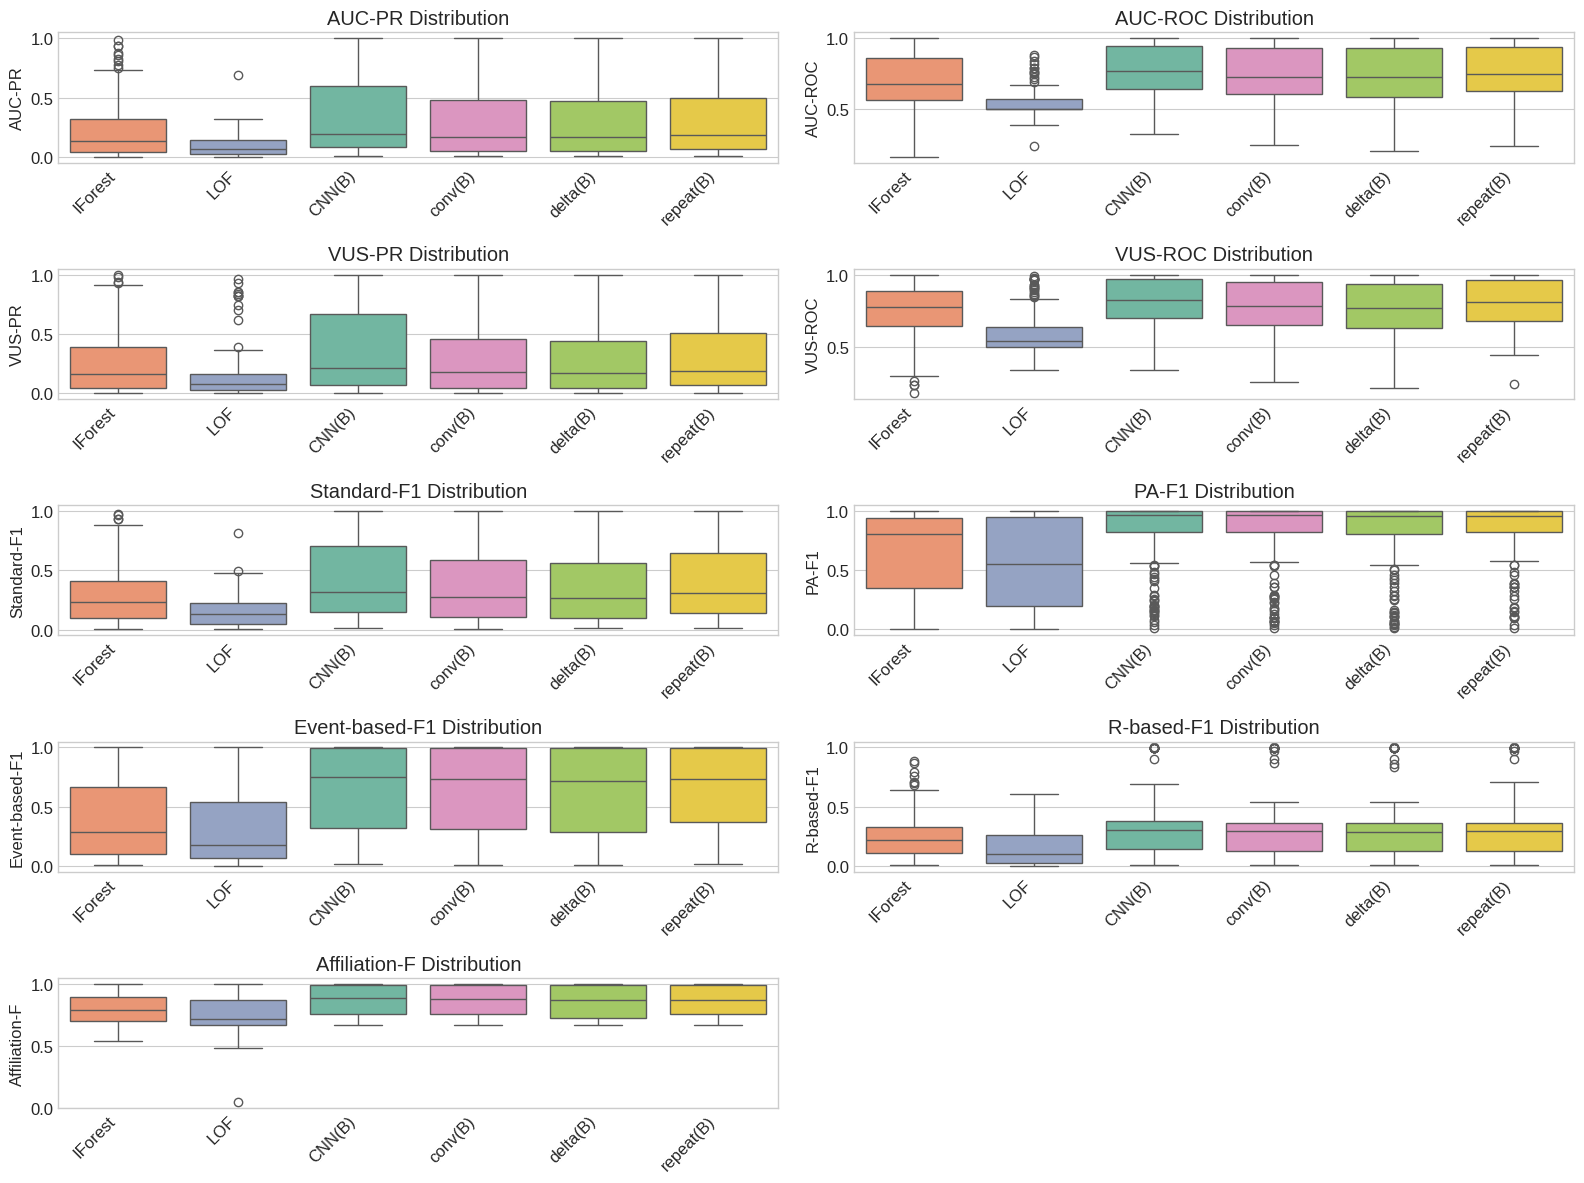

In [161]:
# Plot boxplots for all metrics except 'Time'
metrics_to_plot = [m for m in metric_columns if m != 'Time']
plot_boxplots(combined_df, metrics_to_plot, figsize=(16, 12))

## Visualization 2: Radar Chart of Average Performance

Visualize the average performance of each model across different metrics.

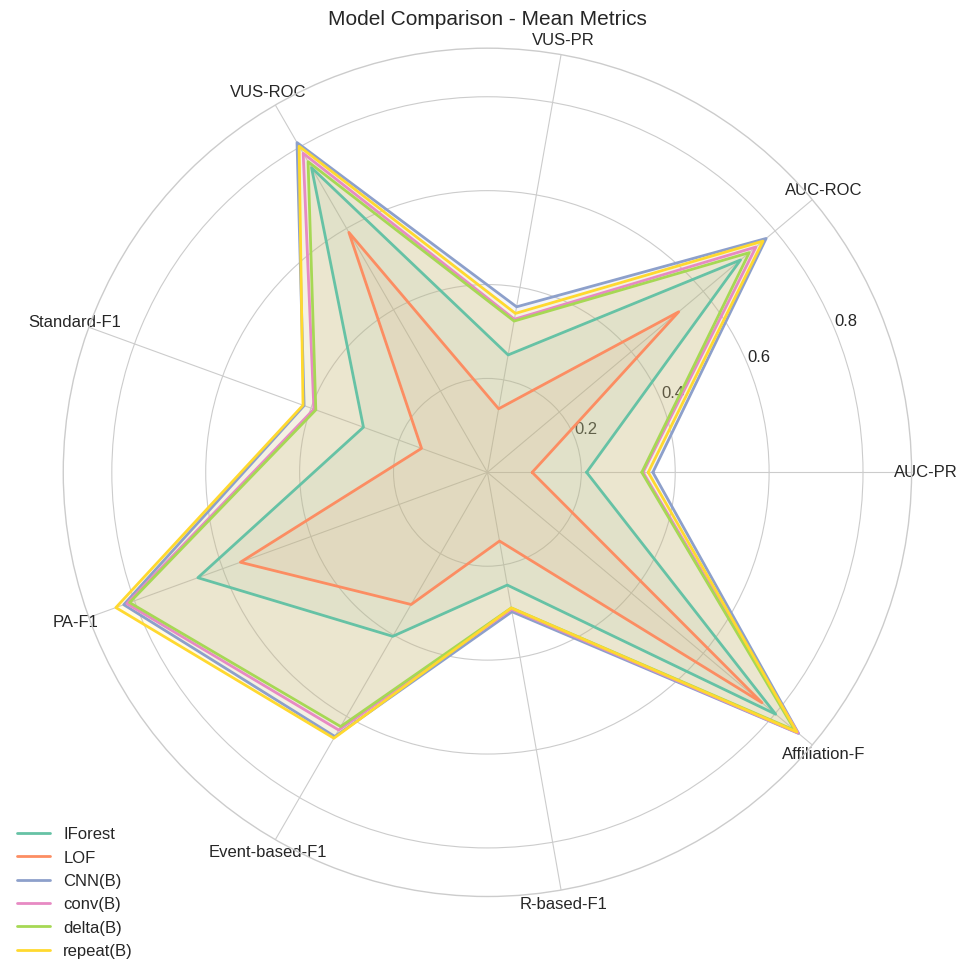

In [162]:
# Create radar chart
plot_radar_chart(dataframes, metrics_to_plot)

## Visualization 3: Correlation Between Metrics

Analyze how different metrics are correlated with each other.

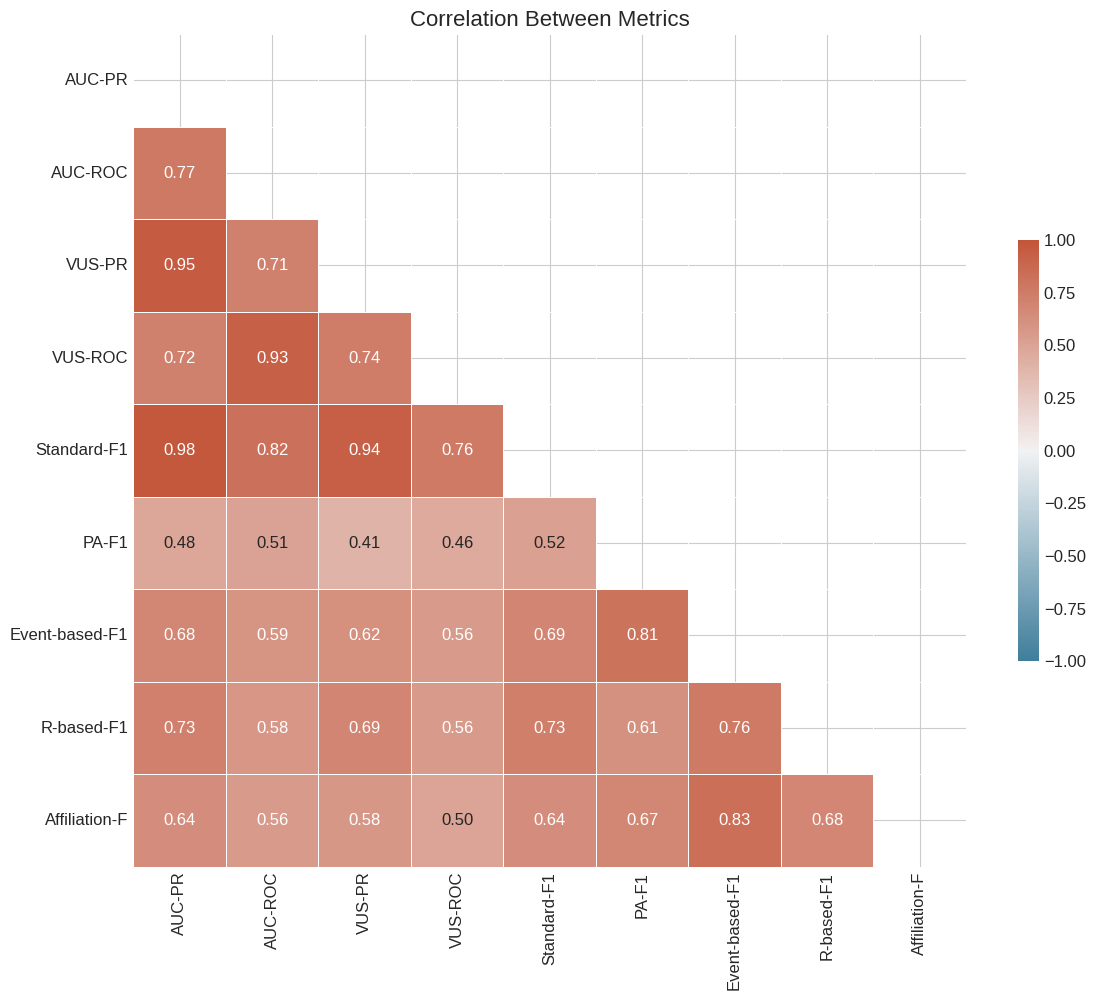

In [163]:
# Plot correlation matrix
plot_metric_correlation(combined_df, metrics_to_plot)

## Visualization 4: Performance Summary by Model

Compare average performance of each model across metrics.

,AUC-PR,AUC-ROC,VUS-PR,VUS-ROC,Standard-F1,PA-F1,Event-based-F1,R-based-F1,Affiliation-F
IForest,0.211261,0.703823,0.253937,0.749339,0.281012,0.656263,0.403324,0.243799,0.801434
LOF,0.095302,0.531972,0.137462,0.590148,0.149338,0.560016,0.325039,0.148595,0.763454
CNN(B),0.352416,0.775019,0.358000,0.811105,0.415479,0.824317,0.649735,0.301457,0.864969
conv(B),0.331535,0.746772,0.331165,0.784761,0.393316,0.817383,0.633734,0.296230,0.863649
delta(B),0.328806,0.727914,0.327168,0.764052,0.388949,0.811060,0.625190,0.293242,0.855143
repeat(B),0.342552,0.766263,0.343750,0.802033,0.417957,0.842189,0.653929,0.293288,0.860340


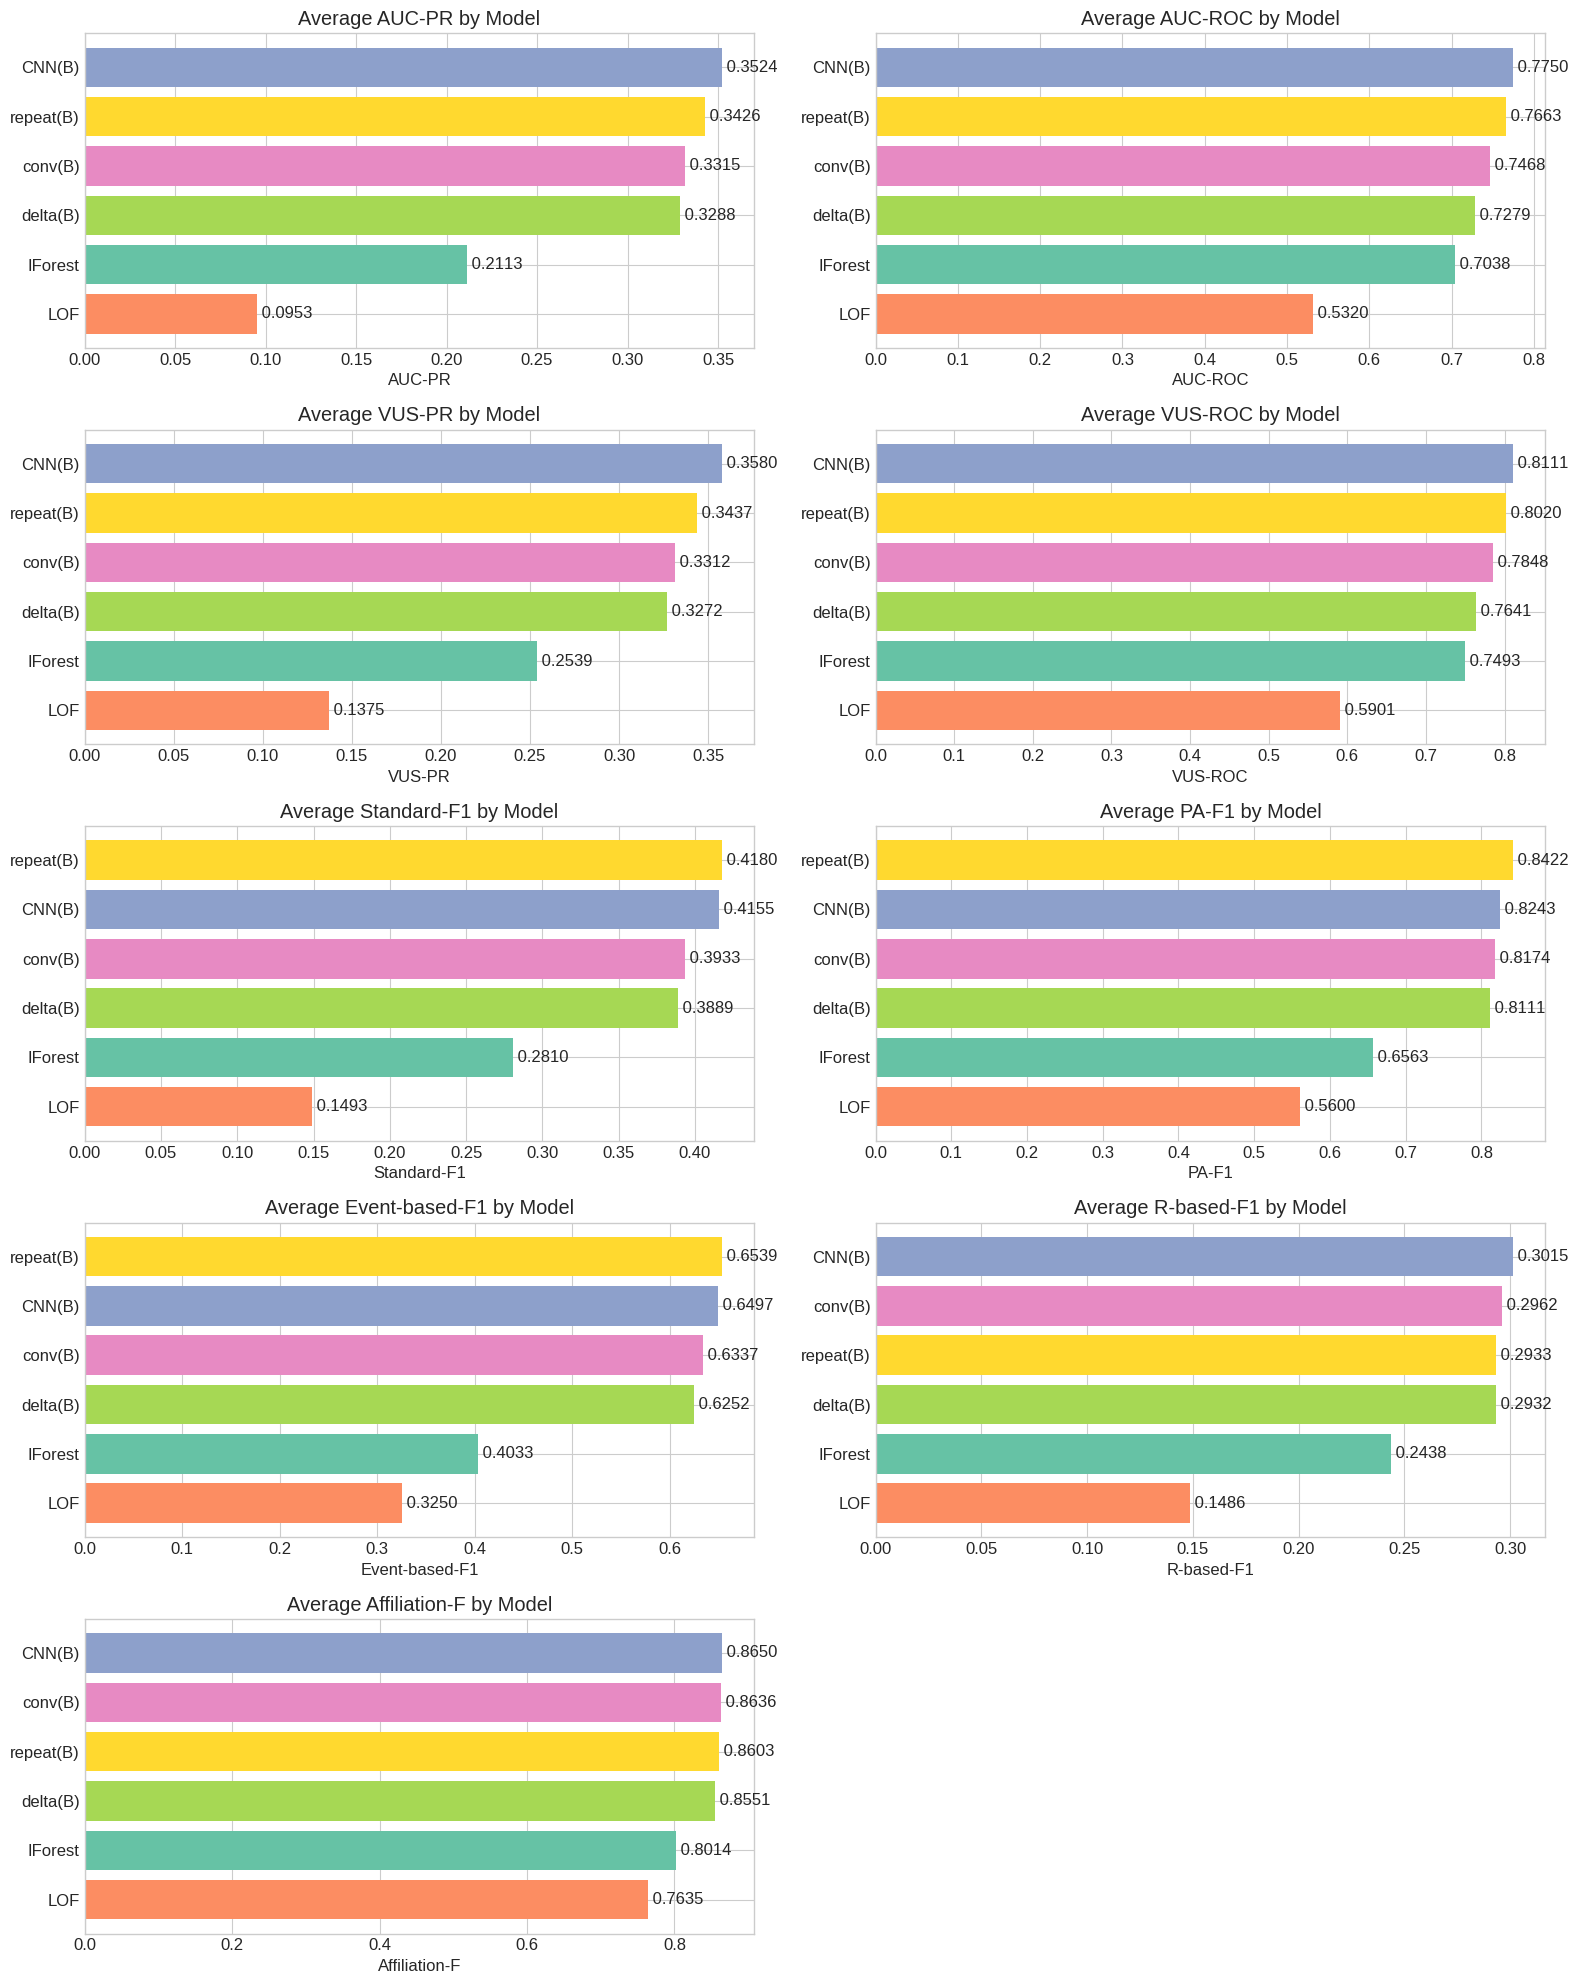

In [164]:
# Generate summary statistics and plots
summary_df = plot_metrics_summary(dataframes, metrics_to_plot)

# Show summary dataframe
display(summary_df.style.background_gradient(cmap='viridis'))

## Visualization 5: Performance Comparison by Dataset

Compare models' performance for a specific metric on individual datasets.

/tmp/ipykernel_3914653/797019456.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_counts.index, y=model_counts.values, palette=palette)


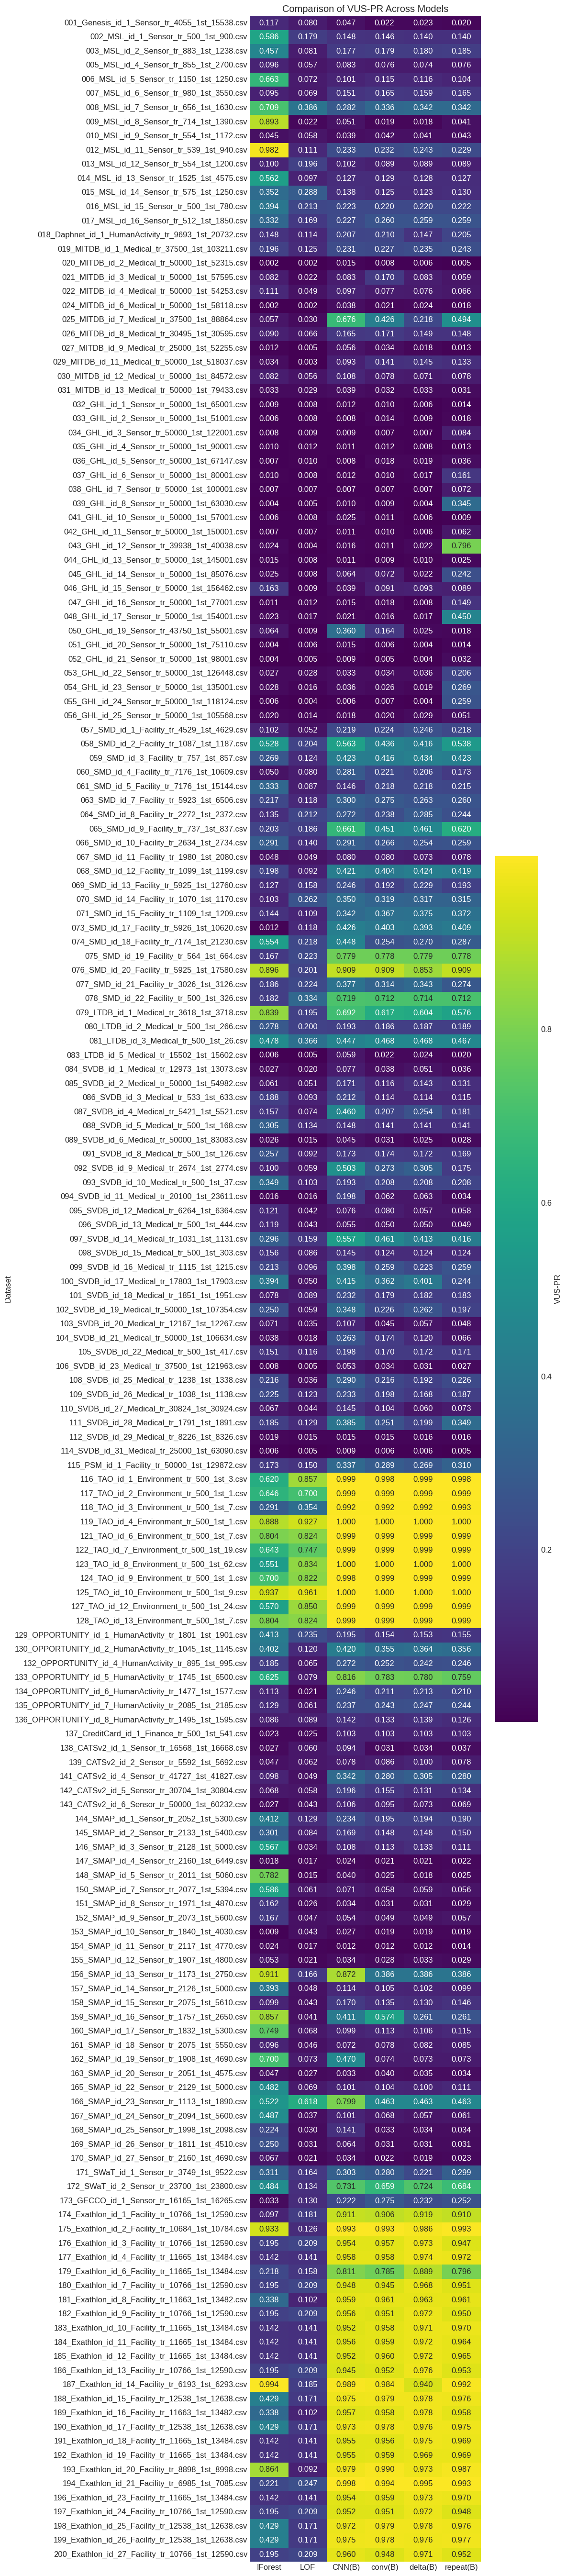

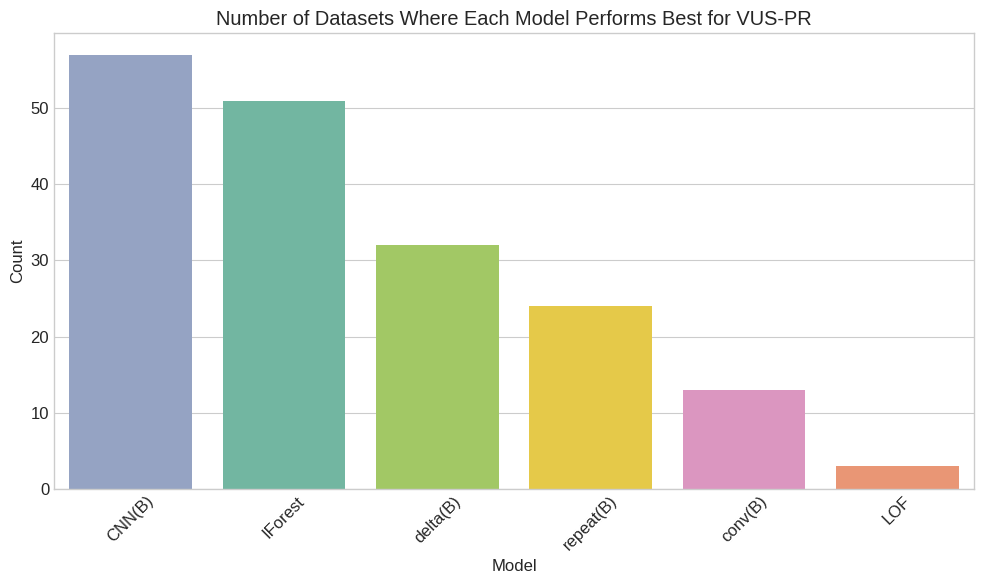

In [165]:
# Choose a metric for detailed comparison (e.g., F1 score)
metric_for_heatmap = 'VUS-PR'  # Change this to any metric of interest

# Create heatmap comparison (only showing first 20 datasets for readability)
comparison_df = plot_performance_heatmap(dataframes, metric_for_heatmap)

# Find the best model for each dataset for the chosen metric
best_model_df = comparison_df.idxmax(axis=1).reset_index()
best_model_df.columns = ['Dataset', 'Best Model']

# Count how many datasets each model is best for
model_counts = best_model_df['Best Model'].value_counts()

#models = ['CNN', 'conv', 'conv(L)', 'delta', 'repeat', 'sthres', 'sthres(L)']
models = model_names
palette = {model: f'C{i}' for i, model in enumerate(models)}

plt.figure(figsize=(10, 6))
sns.barplot(x=model_counts.index, y=model_counts.values, palette=palette)
plt.title(f'Number of Datasets Where Each Model Performs Best for {metric_for_heatmap}')
plt.ylabel('Count')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the best model counts figure
plt.savefig(os.path.join(save_dir_path, 'best_model_counts.png'))

In [166]:
# Run this cell to find the best model for each metric across all datasets
metrics_to_check = metrics_to_plot
best_models = {}

for metric in metrics_to_check:
    # Calculate average performance for this metric
    model_performance = {model: df[metric].mean() for model, df in dataframes.items()}
    best_model = max(model_performance.items(), key=lambda x: x[1])
    best_models[metric] = best_model

# Display results in a DataFrame
results = []
for metric, (model, value) in best_models.items():
    results.append({'Metric': metric, 'Best Model': model, 'Average Score': value})

results_df = pd.DataFrame(results)
display(results_df)

,Metric,Best Model,Average Score
0,AUC-PR,CNN(B),0.352416
1,AUC-ROC,CNN(B),0.775019
2,VUS-PR,CNN(B),0.358000
3,VUS-ROC,CNN(B),0.811105
4,Standard-F1,repeat(B),0.417957
5,PA-F1,repeat(B),0.842189
6,Event-based-F1,repeat(B),0.653929
7,R-based-F1,CNN(B),0.301457
8,Affiliation-F,CNN(B),0.864969


## Visualization 6: Execution Time Analysis

Compare the execution time across different models to evaluate computational efficiency.

,model,mean,median,min,max,std
0,CNN(B),15.306096,7.302134,0.447695,78.690673,17.660871
2,LOF,29.386513,1.308319,0.057200,1133.536655,104.097795
1,IForest,59.451285,20.303895,0.470488,828.114948,93.631528
4,delta(B),69.359291,44.544853,2.292792,480.445218,74.207787
5,repeat(B),70.350179,43.394250,1.750402,585.212700,81.296104
3,conv(B),84.919812,45.979598,2.301026,485.932027,97.319869


/tmp/ipykernel_3914653/3001295759.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_stats['model'], y=time_stats['mean'], palette=palette)


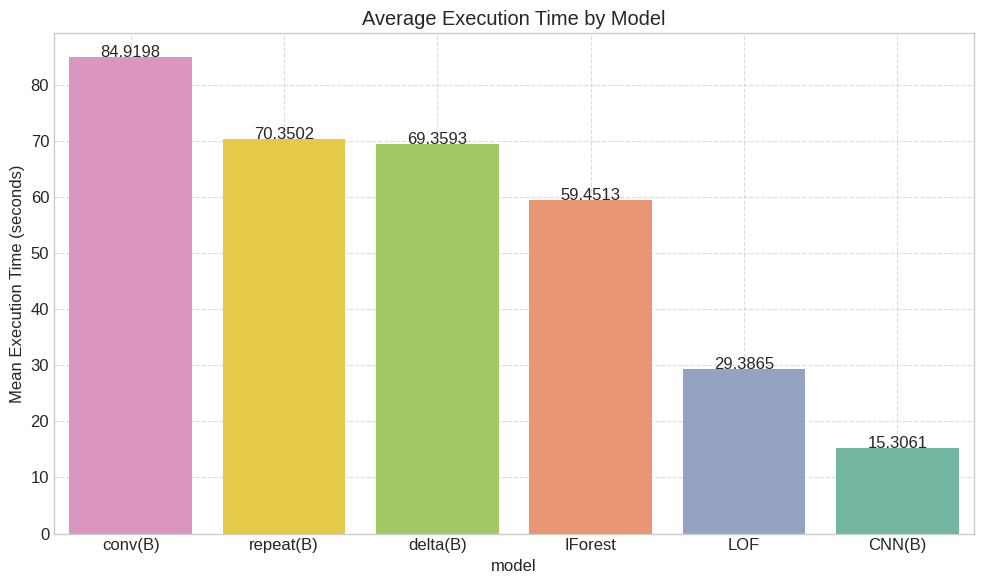

Datasets with largest execution time differences between models:


model,IForest,LOF,CNN(B),conv(B),delta(B),repeat(B),max_diff
file,,,,,,,
020_MITDB_id_2_Medical_tr_50000_1st_52315.csv,53.066365,1133.536655,78.690673,186.314318,147.409142,149.013871,1080.470290
172_SWaT_id_2_Sensor_tr_23700_1st_23800.csv,828.114948,101.269129,54.460481,440.968827,284.479752,295.240655,773.654467
104_SVDB_id_21_Medical_tr_50000_1st_106634.csv,18.153680,58.118901,62.345513,485.932027,261.694269,585.212700,567.059020
085_SVDB_id_2_Medical_tr_50000_1st_54982.csv,20.132962,70.368680,45.880539,210.842076,480.445218,490.308197,470.175235
029_MITDB_id_11_Medical_tr_50000_1st_518037.csv,46.779516,477.830071,46.592735,244.123400,140.085636,201.696151,431.237336
143_CATSv2_id_6_Sensor_tr_50000_1st_60232.csv,137.409779,18.460850,45.298762,438.114151,213.087915,177.413377,419.653301
021_MITDB_id_3_Medical_tr_50000_1st_57595.csv,39.599873,450.466606,47.187216,178.208488,116.355742,201.175509,410.866733
110_SVDB_id_27_Medical_tr_30824_1st_30924.csv,17.191483,75.944443,31.974346,411.952403,142.360268,254.143256,394.760920
141_CATSv2_id_4_Sensor_tr_41727_1st_41827.csv,128.398142,18.460156,43.397645,410.527961,174.146584,174.395962,392.067805



Model efficiency (VUS-PR/Time ratio):


,model,avg_performance,avg_time,efficiency_ratio
2,CNN(B),0.358000,15.306096,0.023389
5,repeat(B),0.343750,70.350179,0.004886
4,delta(B),0.327168,69.359291,0.004717
1,LOF,0.137462,29.386513,0.004678
0,IForest,0.253937,59.451285,0.004271
3,conv(B),0.331165,84.919812,0.003900


/tmp/ipykernel_3914653/3001295759.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='efficiency_ratio', data=efficiency_df, palette=palette)


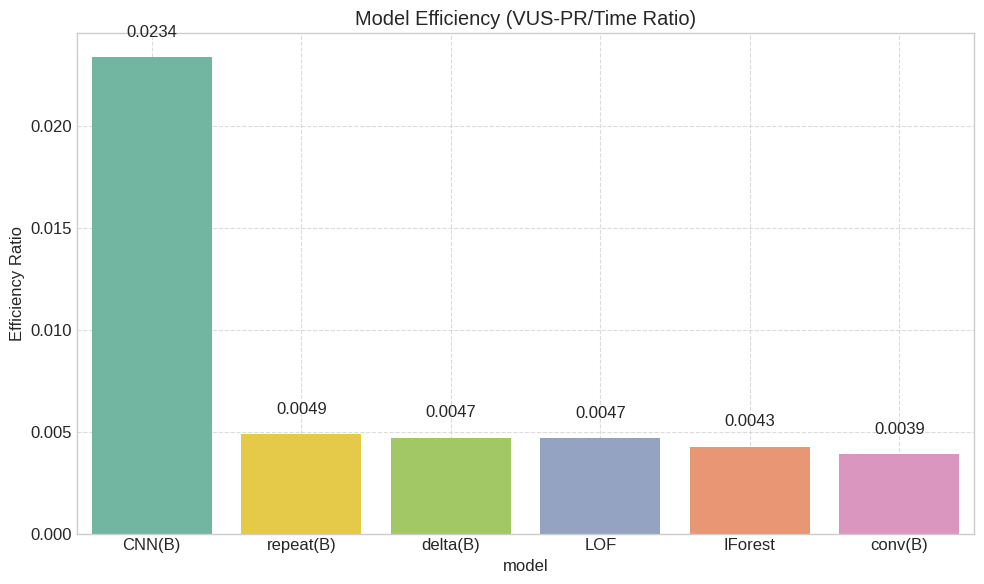

In [167]:
# Modified Execution Time Analysis block
# Analyze execution time across models
time_df = combined_df[['model', 'Time', 'file']]

# Calculate summary statistics for execution time
time_stats = time_df.groupby('model')['Time'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
display(time_stats.sort_values('mean'))

# Define a palette mapping for models
models = sorted(time_df['model'].unique())
palette = {model: f'C{i}' for i, model in enumerate(models)}

'''
# Create boxplot to visualize distribution of execution times with model-specific colors
plt.figure(figsize=(12, 6))
sns.boxplot(x='model', y='Time', data=time_df, palette=palette)
plt.title('Distribution of Execution Time by Model')
plt.ylabel('Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(save_dir_path, 'execution_time_boxplot.png'))
plt.show()

# Violin plot for better distribution visibility with model-specific colors
plt.figure(figsize=(12, 6))
sns.violinplot(x='model', y='Time', data=time_df, inner='box', palette=palette)
plt.title('Distribution of Execution Time by Model')
plt.ylabel('Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(save_dir_path, 'execution_time_violin.png'))
plt.show()
'''

# Create bar chart of average execution time
plt.figure(figsize=(10, 6))

# 크기 순 정렬
time_stats = time_stats.sort_values('mean', ascending=False)

sns.barplot(x=time_stats['model'], y=time_stats['mean'], palette=palette)
plt.title('Average Execution Time by Model')
plt.ylabel('Mean Execution Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
for i, v in enumerate(time_stats['mean']):
    # 만약 models 리스트의 길이가 8 이상이라면 text를 45도 회전
    if len(models) >= 8:
        plt.text(i, v + 0.001, f"{v:.4f}", ha='center', rotation=45)
    else:
        # 그렇지 않으면 수평으로 표시
        plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

# 만약 models 리스트의 길이가 8 이상이라면 x축 레이블을 회전시킴
if len(models) >= 8:
    plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(save_dir_path, 'average_execution_time.png'))
plt.show()

performance_metric = 'VUS-PR'  # Choose any performance metric
'''
# Analyze relationship between execution time and a performance metric
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Time', y=performance_metric, hue='model', data=combined_df, alpha=0.7)
plt.title(f'Relationship Between Execution Time and {performance_metric}')
plt.xlabel('Execution Time (seconds)')
plt.ylabel(performance_metric)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(save_dir_path, 'execution_time_scatter.png'))
plt.show()
'''

# Find datasets with largest time differences between models
time_pivot = time_df.pivot_table(index='file', columns='model', values='Time')
time_pivot['max_diff'] = time_pivot.max(axis=1) - time_pivot.min(axis=1)
largest_diff = time_pivot.nlargest(10, 'max_diff')[model_names + ['max_diff']]
print("Datasets with largest execution time differences between models:")
display(largest_diff)

# Performance-time efficiency analysis
# Calculate efficiency as performance/time ratio using concat instead of append
efficiency_rows = []
for model in model_names:
    model_data = combined_df[combined_df['model'] == model]
    efficiency = model_data[performance_metric].mean() / model_data['Time'].mean()
    efficiency_rows.append({
        'model': model,
        'avg_performance': model_data[performance_metric].mean(),
        'avg_time': model_data['Time'].mean(),
        'efficiency_ratio': efficiency
    })
    
efficiency_df = pd.DataFrame(efficiency_rows)
efficiency_df = efficiency_df.sort_values('efficiency_ratio', ascending=False)
print(f"\nModel efficiency ({performance_metric}/Time ratio):")
display(efficiency_df)

# Plot efficiency ratio
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='efficiency_ratio', data=efficiency_df, palette=palette)
plt.title(f'Model Efficiency ({performance_metric}/Time Ratio)')
plt.ylabel('Efficiency Ratio')
plt.grid(True, linestyle='--', alpha=0.7)
for i, v in enumerate(efficiency_df['efficiency_ratio']):
    # 만약 models 리스트의 길이가 8 이상이라면 text를 45도 회전
    if len(models) >= 8:
        plt.text(i, v + 0.001, f"{v:.4f}", ha='center', rotation=45)
    else:
        # 그렇지 않으면 수평으로 표시
        plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

# 만약 models 리스트의 길이가 8 이상이라면 x축 레이블을 회전시킴
if len(models) >= 8:
    plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(save_dir_path, 'model_efficiency.png'))
plt.show()